# Regression Neural Network to predict housing prices

Training a neural network to predict housing prices on the Boston Housing prices dataset

In [5]:
from keras.datasets import boston_housing
from keras import models
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## The Boson Housing prices dataset

In [6]:
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

57344/57026 [==============================] - 0s 1us/step


Lets look at the dimensions and a couple of samples from the dataset

In [7]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


There are 404 training samples and 102 testing samples, we should keep this in mind since this is a relatively small amount of data available

In [8]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [9]:
train_data[1]

array([2.1770e-02, 8.2500e+01, 2.0300e+00, 0.0000e+00, 4.1500e-01,
       7.6100e+00, 1.5700e+01, 6.2700e+00, 2.0000e+00, 3.4800e+02,
       1.4700e+01, 3.9538e+02, 3.1100e+00])

It seems like there are 13 categories of features with each feature having different ranges of values 

In [14]:
train_labels[0]

15.2

In [16]:
train_labels[1]

42.3

In [19]:
np.max(train_labels)

50.0

In [23]:
np.min(train_labels)

5.0

The labels contain the median values of owner occupied homes, in thousands of dollars. 

This makes sense, since this data was collected in the mid 1970s, if only housing prices were like this nowadays.......

## Preparing the data

Before we can feed the data to the neural net, we have to preprocess the data. Notice that the features were in different ranges of values, we can perform some feature engineering before training to let the neural net have an easier time learning from training data

### Feature-wise normalization

We will calculate the mean of every column and subtract it from the training data divide it by the standard deviation.

This will give us features centered at 0 with a unit std deviation

In [155]:
mean = train_data.mean(axis=0)
train_data -= mean
std_dev = train_data.std(axis=0)
train_data /= std_dev

We will also normalize the test data, but with the values we calculated from the training data.
This is to ensure that we never use any values calculated using the test data so that the test data is not factored into the training of a model

In [28]:
test_data -= mean
test_data /= std_dev

In [29]:
train_data[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

The data is looking better, with this we can start building the model

## Model definition

Since there is very little data available, if we use a big model, it will be very prone to overfitting to the data. One way to mitigate this would be to use a less layers. We won't have an activation for the last layer because if we did include one, then we would restrict the output of our neural net, for example if sigmoid was used, then we would only get back values of 0 - 1.

We will define our model as follows:
    - two intermediate layers of 64 neurons with activation function of relu
    - output layer of 1 neuron (for the price prediction) with no activation, since this is a prediction for scalar regression (regression for single continuous value)
    - optimizer of Adam, loss of mean squared error (for scalar regression), and we will keep track of mean absolute error, which is the absolute value of the distance between the predictions and the targets

In [126]:
def create_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(13,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer = 'Adam', loss = 'mse', metrics = ['mae'])
    return model

In [40]:
create_model()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Validation using K-fold 

Due to the limited size of the data available, inorder to avoid high variance in the error for validating this model, we will use k-fold validation. Depending on your split of training and validation data, the variance can be very high due to the scarce availability of data.

### K-fold implementation

We will create a K-fold of the training data with K = 4 to get a easy to work with value, typically K = 4 or 5 is used 

In [111]:
k = 4
num_samp_per_fold = len(train_data)// k
epochs = 100
scores = []

We will train the model with 100 epochs and a batch_size of 1 (since we are doing k folds).

In [112]:
def train_model():
    for i in range(k):
        print('Training on fold #', i + 1)
        val_data = train_data[i * num_samp_per_fold: (i + 1) * num_samp_per_fold]
        val_labels = train_labels[i * num_samp_per_fold: (i + 1) * num_samp_per_fold]
        #We concantenate the tensors on the columns from everything excluding the data from the current iteration of the K-fold
        partial_train_data = np.concatenate(
            [train_data[:i * num_samp_per_fold], 
            train_data[(i + 1) * num_samp_per_fold:]], 
            axis = 0)
        partial_train_labels = np.concatenate(
            [train_labels[:i* num_samp_per_fold],
             train_labels[(i + 1) * num_samp_per_fold:]],
             axis = 0)
        model = create_model()
        model.fit(partial_train_data, partial_train_labels, epochs = 100, batch_size = 1)
        mse,mae = model.evaluate(val_data, val_labels)
        scores.append(mae)


In [113]:
train_model()

Training on fold # 1
Epoch 1/100
303/303 [==============================] - 2s 8ms/step - loss: 185.5864 - mean_absolute_error: 10.2437
Epoch 2/100
303/303 [==============================] - 1s 2ms/step - loss: 28.1574 - mean_absolute_error: 3.6570
Epoch 3/100
303/303 [==============================] - 1s 2ms/step - loss: 21.0205 - mean_absolute_error: 3.1652
Epoch 4/100
303/303 [==============================] - 1s 2ms/step - loss: 17.8732 - mean_absolute_error: 2.9546
Epoch 5/100
303/303 [==============================] - 1s 2ms/step - loss: 14.8222 - mean_absolute_error: 2.6792
Epoch 6/100
303/303 [==============================] - 1s 2ms/step - loss: 13.4552 - mean_absolute_error: 2.5790
Epoch 7/100
303/303 [==============================] - 1s 2ms/step - loss: 12.2102 - mean_absolute_error: 2.5683
Epoch 8/100
303/303 [==============================] - 1s 2ms/step - loss: 11.1978 - mean_absolute_error: 2.3687
Epoch 9/100
303/303 [==============================] - 1s 2ms/step - loss

303/303 [==============================] - 1s 2ms/step - loss: 3.0525 - mean_absolute_error: 1.3291
Epoch 73/100
303/303 [==============================] - 1s 3ms/step - loss: 3.0787 - mean_absolute_error: 1.3078
Epoch 74/100
303/303 [==============================] - 1s 2ms/step - loss: 2.9431 - mean_absolute_error: 1.2899
Epoch 75/100
303/303 [==============================] - 1s 2ms/step - loss: 3.1607 - mean_absolute_error: 1.3192
Epoch 76/100
303/303 [==============================] - 1s 2ms/step - loss: 2.8635 - mean_absolute_error: 1.2715
Epoch 77/100
303/303 [==============================] - 1s 2ms/step - loss: 2.7719 - mean_absolute_error: 1.2368
Epoch 78/100
303/303 [==============================] - 1s 2ms/step - loss: 2.5630 - mean_absolute_error: 1.2112
Epoch 79/100
303/303 [==============================] - 1s 2ms/step - loss: 3.1916 - mean_absolute_error: 1.3311
Epoch 80/100
303/303 [==============================] - 1s 2ms/step - loss: 2.8179 - mean_absolute_error: 1.2

303/303 [==============================] - 1s 2ms/step - loss: 4.9762 - mean_absolute_error: 1.5833
Epoch 43/100
303/303 [==============================] - 1s 2ms/step - loss: 4.4427 - mean_absolute_error: 1.5075
Epoch 44/100
303/303 [==============================] - 1s 2ms/step - loss: 4.4059 - mean_absolute_error: 1.5610
Epoch 45/100
303/303 [==============================] - 1s 2ms/step - loss: 4.3019 - mean_absolute_error: 1.4768
Epoch 46/100
303/303 [==============================] - 1s 3ms/step - loss: 4.1232 - mean_absolute_error: 1.4813
Epoch 47/100
303/303 [==============================] - 1s 2ms/step - loss: 4.0118 - mean_absolute_error: 1.4862
Epoch 48/100
303/303 [==============================] - 1s 2ms/step - loss: 3.9976 - mean_absolute_error: 1.4809
Epoch 49/100
303/303 [==============================] - 1s 2ms/step - loss: 3.8002 - mean_absolute_error: 1.4357
Epoch 50/100
303/303 [==============================] - 1s 2ms/step - loss: 3.9566 - mean_absolute_error: 1.4

303/303 [==============================] - 1s 2ms/step - loss: 7.6369 - mean_absolute_error: 2.0424
Epoch 14/100
303/303 [==============================] - 1s 2ms/step - loss: 7.5705 - mean_absolute_error: 2.0569
Epoch 15/100
303/303 [==============================] - 1s 2ms/step - loss: 7.3542 - mean_absolute_error: 1.9531
Epoch 16/100
303/303 [==============================] - 1s 2ms/step - loss: 6.9107 - mean_absolute_error: 1.9461
Epoch 17/100
303/303 [==============================] - 1s 2ms/step - loss: 6.6583 - mean_absolute_error: 1.9054
Epoch 18/100
303/303 [==============================] - 1s 2ms/step - loss: 6.6002 - mean_absolute_error: 1.8882
Epoch 19/100
303/303 [==============================] - 1s 2ms/step - loss: 6.5164 - mean_absolute_error: 1.9057
Epoch 20/100
303/303 [==============================] - 1s 2ms/step - loss: 6.3908 - mean_absolute_error: 1.8492
Epoch 21/100
303/303 [==============================] - 1s 2ms/step - loss: 5.7245 - mean_absolute_error: 1.8

303/303 [==============================] - 1s 2ms/step - loss: 2.1347 - mean_absolute_error: 1.1384
Epoch 86/100
303/303 [==============================] - 1s 2ms/step - loss: 2.0824 - mean_absolute_error: 1.1166
Epoch 87/100
303/303 [==============================] - 1s 2ms/step - loss: 2.2741 - mean_absolute_error: 1.1581
Epoch 88/100
303/303 [==============================] - 1s 3ms/step - loss: 2.1791 - mean_absolute_error: 1.0892
Epoch 89/100
303/303 [==============================] - 1s 3ms/step - loss: 2.2667 - mean_absolute_error: 1.1284
Epoch 90/100
303/303 [==============================] - 1s 2ms/step - loss: 1.8855 - mean_absolute_error: 1.0341
Epoch 91/100
303/303 [==============================] - 1s 2ms/step - loss: 2.0164 - mean_absolute_error: 1.0795
Epoch 92/100
303/303 [==============================] - 1s 2ms/step - loss: 1.9493 - mean_absolute_error: 1.0438
Epoch 93/100
303/303 [==============================] - 1s 2ms/step - loss: 1.8461 - mean_absolute_error: 1.0

303/303 [==============================] - 1s 2ms/step - loss: 3.9373 - mean_absolute_error: 1.3803
Epoch 57/100
303/303 [==============================] - 1s 2ms/step - loss: 3.8948 - mean_absolute_error: 1.4183
Epoch 58/100
303/303 [==============================] - 1s 2ms/step - loss: 4.1901 - mean_absolute_error: 1.4390
Epoch 59/100
303/303 [==============================] - 1s 2ms/step - loss: 4.0174 - mean_absolute_error: 1.3893
Epoch 60/100
303/303 [==============================] - 1s 2ms/step - loss: 3.8233 - mean_absolute_error: 1.3761
Epoch 61/100
303/303 [==============================] - 1s 2ms/step - loss: 4.1279 - mean_absolute_error: 1.4163
Epoch 62/100
303/303 [==============================] - 1s 2ms/step - loss: 3.6453 - mean_absolute_error: 1.3759
Epoch 63/100
303/303 [==============================] - 1s 2ms/step - loss: 3.3372 - mean_absolute_error: 1.3125
Epoch 64/100
303/303 [==============================] - 1s 2ms/step - loss: 3.6214 - mean_absolute_error: 1.3

In [115]:
np.mean(scores)

2.56865270952187

We have a average of of ~2.5 thousand mean absolute error. 

Lets train for more epochs and see if the model will perform better.

In [139]:
def train_model_v2(epochs = 500):
    score = []
    for i in range(k):
        print("Training on iteration #", i + 1)
        val_data = train_data[i * num_samp_per_fold: (i + 1) * num_samp_per_fold]
        val_labels = train_labels[i * num_samp_per_fold: (i + 1) * num_samp_per_fold]
        
        partial_train_data = np.concatenate( 
            [train_data[: i * num_samp_per_fold],
            train_data[(i+1) * num_samp_per_fold:]],
            axis = 0)
        partial_train_labels = np.concatenate(
            [train_labels[: i * num_samp_per_fold], 
            train_labels[(i+1) * num_samp_per_fold:]],
            axis = 0)
        
        model = create_model()
        # Training text was cutoff, as shown above, 400 lines of output can be pretty long....
        history = model.fit(partial_train_data, partial_train_labels, epochs = epochs, batch_size = 1, validation_data = (val_data, val_labels),verbose = 0)
        mae_per_epoch = history.history['val_mean_absolute_error']
        score.append(mae_per_epoch)
    return score

In [140]:
score = train_model_v2()

Training on iteration # 1
Training on iteration # 2
Training on iteration # 3
Training on iteration # 4


### Computing the average mae scores per epoch

In [141]:
avg_mae_per_epoch = [np.mean([x[i] for x in score]) for i in range(500)]

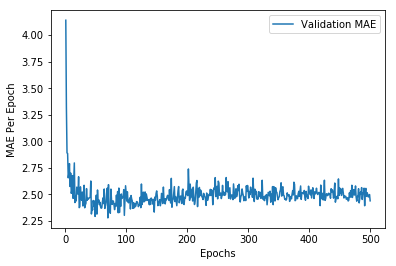

In [142]:
epochs = range(1, len(avg_mae_per_epoch) + 1)

plt.plot(epochs, avg_mae_per_epoch, label = "Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE Per Epoch")
plt.legend()
plt.show()

### Smoothing avg mae scores per epoch

The graph above is a little hard to read, inorder to increase visibility, lets smooth the graph by replacing the points with an exponential moving average of the previous points

In [148]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

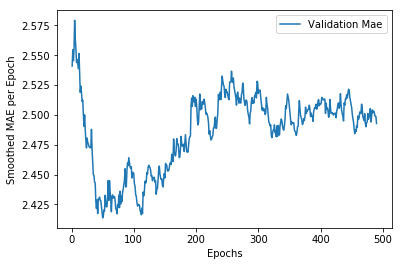

In [152]:
smoothed_mae = smooth_curve(avg_mae_per_epoch[10:])
epochs = range(1, len(smoothed_mae) + 1)

plt.clf()
plt.plot(epochs, smoothed_mae, label = "Validation Mae")
plt.xlabel("Epochs")
plt.ylabel("Smoothed MAE per Epoch")
plt.legend()
plt.show()

### Summary

It seems like the validation MAE stops improving around 100 epochs, after that the model starts to overfit. 

## Conclusion

It seems like our earlier model trained on 100 epochs had better accuracy for unseen data then training it on 500 epochs where it is overfitting on the training data.